### Distilling the Knowledge in a Neural Network

https://arxiv.org/pdf/1503.02531.pdf

In [1]:
from importlib import reload
import models
reload(models)
from __future__ import print_function
import keras
from keras import utils
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import optimizers
import numpy as np
from keras.callbacks import ModelCheckpoint  

Using TensorFlow backend.


In [2]:
batch_size = 1000
num_classes = 10
epochs = 60

# input image dimensions
img_rows, img_cols = 32, 32

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)
input_shape = (img_rows, img_cols, 3)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)
50000 train samples
10000 test samples


In [3]:
model = dict()
hist = dict()
score = dict()
preds = dict()

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

test_datagen = ImageDataGenerator()

train_datagen.fit(x_train)
#test_datagen.fit(x_test)

In [116]:
reload(models)
model['teacher'] = models.TeacherModel_CIFAR(input_shape, num_classes)

model['teacher'].compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])
model['teacher'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_35 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 28, 28, 128)       147584    
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_35 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_103 (Dense)            (None, 1024)              25691136  
__________

In [12]:
checkpointer = ModelCheckpoint(filepath='saved_models_cifar10/weights.best.teacher.hdf5', 
                               verbose=0, save_best_only=True)

hist['teacher'] = model['teacher'].fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                                                           steps_per_epoch=len(x_train) // batch_size, 
                                                           epochs=100, verbose=1, 
#                                                            validation_data=test_datagen.flow(x_test, y_test), 
#                                                            validation_steps=len(x_train) // batch_size,
                                                           validation_data=(x_test, y_test),
                                                           callbacks=[checkpointer])
score['teacher'] = model['teacher'].evaluate(x_test, y_test, verbose=0)
print('Test loss:', score['teacher'][0])
print('Test accuracy:', score['teacher'][1])

Epoch 1/100
50/50 [==============================] - 35s 704ms/step - loss: 1.9814 - acc: 0.2624 - val_loss: 1.5423 - val_acc: 0.4323
Epoch 2/100
50/50 [==============================] - 52s 1s/step - loss: 1.5349 - acc: 0.4370 - val_loss: 1.2934 - val_acc: 0.5312
Epoch 3/100
50/50 [==============================] - 55s 1s/step - loss: 1.3885 - acc: 0.4974 - val_loss: 1.1992 - val_acc: 0.5679
Epoch 4/100
50/50 [==============================] - 56s 1s/step - loss: 1.2966 - acc: 0.5353 - val_loss: 1.1610 - val_acc: 0.5877
Epoch 5/100
50/50 [==============================] - 63s 1s/step - loss: 1.2153 - acc: 0.5667 - val_loss: 1.0068 - val_acc: 0.6441
Epoch 6/100
50/50 [==============================] - 63s 1s/step - loss: 1.1437 - acc: 0.5929 - val_loss: 1.0289 - val_acc: 0.6305
Epoch 7/100
50/50 [==============================] - 58s 1s/step - loss: 1.0946 - acc: 0.6090 - val_loss: 0.9392 - val_acc: 0.6726
Epoch 8/100
50/50 [==============================] - 66s 1s/step - loss: 1.0540 

In [13]:
model['teacher'].load_weights('saved_models_cifar10/weights.best.teacher.hdf5')
score['teacher'] = model['teacher'].evaluate(x_test, y_test, verbose=0)
n_errors = np.int((1-score['teacher'][-1])*len(y_test))
print('Test loss:', score['teacher'][0])
print('Test accuracy:', score['teacher'][-1])
print('Test errors:', n_errors)

Test loss: 0.5328555122852325
Test accuracy: 0.8151
Test errors: 1848


In [65]:
reload(models)
model['soft_teacher'] = models.SoftTeacherModel_CIFAR(input_shape, num_classes, l1=0.1, l2=0.05, b=1)

model['soft_teacher'].compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])

In [66]:
checkpointer = ModelCheckpoint(filepath='saved_models_cifar10/weights.best.soft_teacher.hdf5', 
                               verbose=0, save_best_only=True)

model['soft_teacher'].load_weights('saved_models_cifar10/weights.best.soft_teacher.hdf5')
hist['soft_teacher'] = model['soft_teacher'].fit_generator(train_datagen.flow(x_train, y_train, batch_size=batch_size),
                                                           steps_per_epoch=len(x_train) // batch_size, 
                                                           epochs=100, verbose=1, 
#                                                            validation_data=test_datagen.flow(x_test, y_test), 
#                                                            validation_steps=len(x_train) // batch_size,
                                                           validation_data=(x_test, y_test),
                                                           callbacks=[checkpointer])
score['soft_teacher'] = model['soft_teacher'].evaluate(x_test, y_test, verbose=0)
print('Test loss:', score['soft_teacher'][0])
print('Test accuracy:', score['soft_teacher'][1])

Epoch 1/100
50/50 [==============================] - 34s 685ms/step - loss: 1.4914 - acc: 0.8191 - val_loss: 1.5085 - val_acc: 0.8006
Epoch 2/100
50/50 [==============================] - 35s 710ms/step - loss: 1.4818 - acc: 0.8253 - val_loss: 1.5048 - val_acc: 0.8085
Epoch 3/100
50/50 [==============================] - 39s 782ms/step - loss: 1.4834 - acc: 0.8243 - val_loss: 1.4986 - val_acc: 0.8118
Epoch 4/100
50/50 [==============================] - 35s 705ms/step - loss: 1.4795 - acc: 0.8285 - val_loss: 1.5081 - val_acc: 0.8016
Epoch 5/100
50/50 [==============================] - 40s 792ms/step - loss: 1.4808 - acc: 0.8277 - val_loss: 1.4978 - val_acc: 0.8132
Epoch 6/100
50/50 [==============================] - 35s 706ms/step - loss: 1.4800 - acc: 0.8281 - val_loss: 1.5070 - val_acc: 0.8025
Epoch 7/100
50/50 [==============================] - 32s 650ms/step - loss: 1.4746 - acc: 0.8309 - val_loss: 1.5045 - val_acc: 0.8055
Epoch 8/100
50/50 [==============================] - 34s 675ms

KeyboardInterrupt: 

In [67]:
model['soft_teacher'].load_weights('saved_models_cifar10/weights.best.soft_teacher.hdf5')
score['soft_teacher'] = model['soft_teacher'].evaluate(x_test, y_test, verbose=0)
n_errors = np.int((1-score['soft_teacher'][-1])*len(y_test))
print('Test loss:', score['soft_teacher'][0])
print('Test accuracy:', score['soft_teacher'][-1])
print('Test errors:', n_errors)

Test loss: 1.0030821318626404
Test accuracy: 0.8218
Test errors: 1782


In [117]:
reload(models)

model['student'] = models.StudentModel(input_shape, num_classes)
model['student'].compile(loss=keras.losses.categorical_crossentropy,
              optimizer='Adam',
              metrics=['accuracy'])
model['student'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_36 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_36 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_106 (Dense)            (None, 800)               2458400   
_________________________________________________________________
dense_107 (Dense)            (None, 800)               640800    
_________________________________________________________________
dense_108 (Dense)            (None, 10)                8010      
_________________________________________________________________
o2 (Activation)              (None, 10)                0         
Total params: 3,107,210
Trainable params: 3,107,210
Non-trainable params: 0
_________________________________________________________________


In [18]:
checkpointer = ModelCheckpoint(filepath='saved_models_cifar10/weights.best.student.hdf5', 
                               verbose=0, save_best_only=True)

hist['student'] = model['student'].fit(x_train, y_train, batch_size=batch_size,
          epochs=40, verbose=1, validation_data=(x_test, y_test), callbacks=[checkpointer])
score['student'] = model['student'].evaluate(x_test, y_test, verbose=0)
print('Test loss:', score['student'][0])
print('Test accuracy:', score['student'][1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/40
50000/50000 [==============================] - 3s 52us/step - loss: 2.2926 - acc: 0.2319 - val_loss: 1.9007 - val_acc: 0.3131
Epoch 2/40
50000/50000 [==============================] - 2s 38us/step - loss: 1.8179 - acc: 0.3507 - val_loss: 1.7397 - val_acc: 0.3788
Epoch 3/40
50000/50000 [==============================] - 2s 37us/step - loss: 1.7037 - acc: 0.3960 - val_loss: 1.6472 - val_acc: 0.4194
Epoch 4/40
50000/50000 [==============================] - 2s 34us/step - loss: 1.6262 - acc: 0.4260 - val_loss: 1.6332 - val_acc: 0.4285
Epoch 5/40
50000/50000 [==============================] - 3s 56us/step - loss: 1.5952 - acc: 0.4354 - val_loss: 1.5681 - val_acc: 0.4454
Epoch 6/40
50000/50000 [==============================] - 4s 79us/step - loss: 1.5374 - acc: 0.4562 - val_loss: 1.5439 - val_acc: 0.4558
Epoch 7/40
50000/50000 [==============================] - 4s 75us/step - loss: 1.5069 - acc: 0.4664 - val_loss: 1.4909 - val_acc

In [19]:
model['student'].load_weights('saved_models_cifar10/weights.best.student.hdf5')
score['student'] = model['student'].evaluate(x_test, y_test, verbose=0)
n_errors = np.int((1-score['student'][-1])*len(y_test))
print('Test loss:', score['student'][0])
print('Test accuracy:', score['student'][-1])
print('Test errors:', n_errors)

Test loss: 1.306084471321106
Test accuracy: 0.5427
Test errors: 4573


# Knowledge Distilation

In [68]:
kd_gt = dict()
T = 5
kd_gt['t_train'] = model['teacher'].T_model(T).predict(x_train, verbose=1, batch_size=batch_size)
kd_gt['t_test'] = model['teacher'].T_model(T).predict(x_test, verbose=1, batch_size=batch_size)
kd_gt['st_train'] = model['soft_teacher'].predict(x_train, verbose=1, batch_size=batch_size)
kd_gt['st_test'] = model['soft_teacher'].predict(x_test, verbose=1, batch_size=batch_size)

import numpy as np
np.linalg.norm(kd_gt['t_train'], axis=-1).mean(), np.linalg.norm(kd_gt['st_train'], axis=-1).mean()

10000/10000 [==============================] - 1s 82us/step


(0.49204093, 0.5643369)

In [21]:
# import numpy as np
# from keras.activations import softmax

# def softmax_with_temp(x):
#     Temp = 1.0
#     e_x = np.exp((x - x.max(axis=1, keepdims=True))/Temp)
#     out = e_x / e_x.sum(axis=1, keepdims=True)
#     return out

# def soft_with_T(T=1):
#     def swt(x):
#         return softmax(x/T)
#     return swt

In [22]:
''' KNOWLEDGE DISTILLATION WITH REGULAR TEACHER (TEMPERATURE SOFTMAX) '''
reload(models)
model['student_'] = models.StudentModel(input_shape, num_classes, T=T, in_class=True)
model['student_'].compile(loss=['categorical_crossentropy', 'categorical_crossentropy'],
                          loss_weights=[1., 1. / (T**2)],
                          optimizer='Adam',
                          metrics=['acc'])

In [23]:
checkpointer = ModelCheckpoint(filepath='saved_models_cifar10/weights.best.student_.hdf5', 
                               verbose=0, save_best_only=True)

hist['student_'] = model['student_'].fit(x_train, [kd_gt['t_train'], y_train],
          batch_size=batch_size, epochs=200, verbose=1,
          validation_data=(x_test, [kd_gt['t_test'], y_test]), callbacks=[checkpointer])
score['student_'] = model['student_'].evaluate(x_test, [kd_gt['t_test'], y_test], verbose=0)
print('Test loss:', score['student_'][0])
print('Test accuracy:', score['student_'][-1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 3s 67us/step - loss: 2.2854 - o1_loss: 2.1938 - o2_loss: 2.2907 - o1_acc: 0.2719 - o2_acc: 0.2647 - val_loss: 2.2241 - val_o1_loss: 2.1422 - val_o2_loss: 2.0491 - val_o1_acc: 0.3499 - val_o2_acc: 0.3376
Epoch 2/200
50000/50000 [==============================] - 2s 49us/step - loss: 2.1958 - o1_loss: 2.1147 - o2_loss: 2.0275 - o1_acc: 0.3750 - o2_acc: 0.3634 - val_loss: 2.1739 - val_o1_loss: 2.0968 - val_o2_loss: 1.9296 - val_o1_acc: 0.4076 - val_o2_acc: 0.3820
Epoch 3/200
50000/50000 [==============================] - 3s 52us/step - loss: 2.1556 - o1_loss: 2.0777 - o2_loss: 1.9467 - o1_acc: 0.4128 - o2_acc: 0.4002 - val_loss: 2.1434 - val_o1_loss: 2.0698 - val_o2_loss: 1.8417 - val_o1_acc: 0.4483 - val_o2_acc: 0.4231
Epoch 4/200
50000/50000 [==============================] - 2s 50us/step - loss: 2.1347 - o1_loss: 2.0586 - o2_loss: 1.9018 - o1_acc: 0.4340 - o2_acc: 0.4217 - val_l

In [24]:
model['student_'].load_weights('saved_models_cifar10/weights.best.student_.hdf5')
score['student_'] = model['student_'].evaluate(x_test, [kd_gt['t_test'], y_test], verbose=0)
n_errors = np.int((1-score['student_'][-1])*len(y_test))
print('Test loss:', score['student_'][0])
print('Test accuracy:', score['student_'][-1])
print('Test errors:', n_errors)

Test loss: 2.0026373153686525
Test accuracy: 0.573
Test errors: 4270


In [96]:
''' SOFT TEACHER IN CLASS '''
reload(models)
from keras import callbacks

# base_lr = 3e-3
# decay = 0.99
# optim = keras.optimizers.Adam(lr=base_lr)

base_lw = 0.9
base_rw = 0.1
l_decay = 0.95
lw = K.variable(value=0.9)
rw = K.variable(value=0.1)
def decay_lw(epoch, log):
    #maybe use epoch+1, because it starts with 0
    K.set_value(lw, 0.9 * l_decay**epoch)
    K.set_value(rw, 1 - 0.9 * l_decay**epoch)
lw_changer = callbacks.LambdaCallback(on_epoch_end=decay_lw)


model['student_st'] = models.StudentModel(input_shape, num_classes, T=1, in_class=True, l2=0, b=0)
model['student_st'].compile(loss=['categorical_crossentropy', 'categorical_crossentropy'],
                          loss_weights=[rw, lw],
                          optimizer='Adam',
                          metrics=['acc'])

In [97]:
def schedule(epoch):
    return base_lr * decay**(epoch)

#es = callbacks.EarlyStopping(monitor='val_o2_loss', mode='min', verbose=0, patience=30)
#mc = callbacks.ModelCheckpoint('best_student_st.h5', monitor='val_o2_acc', mode='max', verbose=0, save_best_only=True)
ls = callbacks.LearningRateScheduler(schedule)

checkpointer = ModelCheckpoint(filepath='saved_models_cifar10/weights.best.student_st.hdf5', 
                               verbose=0, save_best_only=True, monitor='val_o2_acc')

#model['student_st'].load_weights('saved_models_cifar10/weights.best.student_st.hdf5')
hist['student_st'] = model['student_st'].fit(x_train, [kd_gt['st_train'], y_train],
          batch_size=batch_size,
          epochs=150,
          verbose=1,
          validation_data=(x_test, [kd_gt['st_test'], y_test]),
          callbacks=[lw_changer],
            )
score['student_st'] = model['student_st'].evaluate(x_test, [kd_gt['st_test'], y_test], verbose=0)
print('Test loss:', score['student_st'][0])
print('Test accuracy:', score['student_st'][-1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/150
50000/50000 [==============================] - 4s 87us/step - loss: 2.2750 - o1_loss: 2.3815 - o2_loss: 2.2632 - o1_acc: 0.2360 - o2_acc: 0.2312 - val_loss: 1.9193 - val_o1_loss: 2.1371 - val_o2_loss: 1.8951 - val_o1_acc: 0.3521 - val_o2_acc: 0.3340
Epoch 2/150
50000/50000 [==============================] - 2s 44us/step - loss: 1.8486 - o1_loss: 2.1217 - o2_loss: 1.8183 - o1_acc: 0.3634 - o2_acc: 0.3554 - val_loss: 1.7923 - val_o1_loss: 2.1039 - val_o2_loss: 1.7577 - val_o1_acc: 0.3918 - val_o2_acc: 0.3724
Epoch 3/150
50000/50000 [==============================] - 2s 40us/step - loss: 1.7754 - o1_loss: 2.0927 - o2_loss: 1.7215 - o1_acc: 0.3972 - o2_acc: 0.3891 - val_loss: 1.7428 - val_o1_loss: 2.0705 - val_o2_loss: 1.6872 - val_o1_acc: 0.4292 - val_o2_acc: 0.4122
Epoch 4/150
50000/50000 [==============================] - 2s 39us/step - loss: 1.7394 - o1_loss: 2.0742 - o2_loss: 1.6620 - o1_acc: 0.4225 - o2_acc: 0.4137 - val_l

In [74]:
model['student_st'].load_weights('saved_models_cifar10/weights.best.student_st.hdf5')
score['student_st'] = model['student_st'].evaluate(x_test, [kd_gt['st_test'], y_test], verbose=0)
n_errors = np.int((1-score['student_st'][-1])*len(y_test))
print('Test loss:', score['student_st'][0])
print('Test accuracy:', score['student_st'][-1])
print('Test errors:', n_errors)

Test loss: 1.9920119903564453
Test accuracy: 0.5559
Test errors: 4441


In [28]:
# x_small_train = x_train[np.argmax(y_train, axis=-1) != 3]
# y_small_train = y_train[np.argmax(y_train, axis=-1) != 3]
# x_small_train.shape

In [112]:
reload(models)
from keras import callbacks

base_l2 = 0.05
l2_decay = 0.99
l2_weight = K.variable(base_l2)

def changeAlpha(epoch,logs):
    #maybe use epoch+1, because it starts with 0
    K.set_value(l2_weight, base_l2 * l2_decay**epoch)

l2Changer = callbacks.LambdaCallback(on_epoch_end=changeAlpha)


base_lr = 2e-4
decay = 0.99
optim = keras.optimizers.Adam(lr=base_lr)

model['student_reg'] = models.SoftStudentModel(input_shape, num_classes, l1=0.1, l2=l2_weight, b=3)
model['student_reg'].compile(loss=keras.losses.categorical_crossentropy,
              optimizer=optim,
              metrics=['accuracy'])

In [114]:
def schedule(epoch):
    return base_lr * decay**(epoch)

ls = callbacks.LearningRateScheduler(schedule)
#model['student_reg'].load_weights('saved_models_cifar10/weights.best.student_reg.hdf5')
checkpointer = ModelCheckpoint(filepath='saved_models_cifar10/weights.best.student_reg.hdf5', 
                               verbose=0, save_best_only=True, monitor='val_acc')



hist['student_reg'] = model['student_reg'].fit(x_train, y_train,
          batch_size=batch_size,
          epochs=100,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=[ls, checkpointer, l2Changer],
            )
score['student_reg'] = model['student_reg'].evaluate(x_test, y_test, verbose=0)
print('Test loss:', score['student_reg'][0])
print('Test accuracy:', score['student_reg'][-1])

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 3s 66us/step - loss: 1.9771 - acc: 0.3794 - val_loss: 1.9326 - val_acc: 0.4104
Epoch 2/100
50000/50000 [==============================] - 2s 44us/step - loss: 1.9129 - acc: 0.4100 - val_loss: 1.8990 - val_acc: 0.4211
Epoch 3/100
50000/50000 [==============================] - 2s 44us/step - loss: 1.8756 - acc: 0.4274 - val_loss: 1.8599 - val_acc: 0.4304
Epoch 4/100
50000/50000 [==============================] - 2s 43us/step - loss: 1.8411 - acc: 0.4436 - val_loss: 1.8546 - val_acc: 0.4246
Epoch 5/100
50000/50000 [==============================] - 2s 45us/step - loss: 1.8197 - acc: 0.4537 - val_loss: 1.8160 - val_acc: 0.4519
Epoch 6/100
50000/50000 [==============================] - 2s 43us/step - loss: 1.7898 - acc: 0.4701 - val_loss: 1.8009 - val_acc: 0.4567
Epoch 7/100
50000/50000 [==============================] - 2s 44us/step - loss: 1.7725 - acc: 0.4804 - val_loss: 1.7800 - 

In [115]:
model['student_reg'].load_weights('saved_models_cifar10/weights.best.student_reg.hdf5')
score['student_reg'] = model['student_reg'].evaluate(x_test, y_test, verbose=0)
n_errors = np.int((1-score['student_reg'][-1])*len(y_test))
print('Test loss:', score['student_reg'][0])
print('Test accuracy:', score['student_reg'][-1])
print('Test errors:', n_errors)

Test loss: 1.3251290603637695
Test accuracy: 0.551
Test errors: 4490


# Analysis

In [49]:
T = 5
preds['teacher_no_T'] = model['teacher'].predict(x_train, verbose=1, batch_size=batch_size)
preds['teacher'] = model['teacher'].T_model(T).predict(x_train, verbose=1, batch_size=batch_size)
preds['soft_teacher'] = model['soft_teacher'].predict(x_train, verbose=1, batch_size=batch_size)

import numpy as np
np.linalg.norm(preds['teacher'], axis=-1).mean(), np.linalg.norm(preds['soft_teacher'], axis=-1).mean()

50000/50000 [==============================] - 4s 77us/step


(0.49204093, 0.49514884)

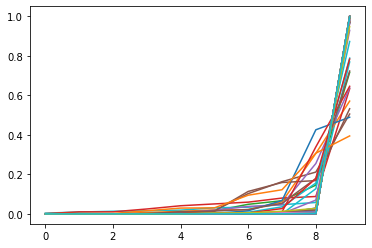

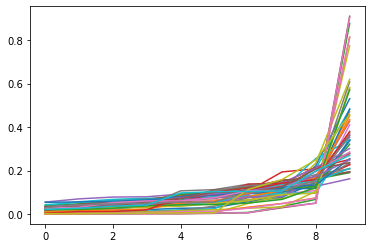

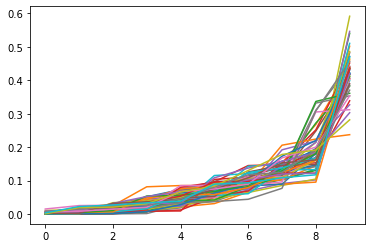

In [50]:
## Plot constrained softmax probabilities generated by the model

import matplotlib.pyplot as plt
ind = np.random.choice(len(preds['teacher_no_T']), 50)
plt.plot(np.sort(preds['teacher_no_T'])[ind].T)
plt.show()

ind = np.random.choice(len(preds['teacher']), 50)
plt.plot(np.sort(preds['teacher'])[ind].T)
plt.show()

ind = np.random.choice(len(preds['soft_teacher']), 50)
plt.plot(np.sort(preds['soft_teacher'])[ind].T)
plt.show()

In [51]:
from collections import Counter

pairs = [(x[-1], x[-2]) for x in np.argsort(preds['soft_teacher'])]
counts = Counter(pairs)
counts.most_common(20)

[((1, 9), 3312),
 ((5, 3), 3173),
 ((7, 5), 2390),
 ((3, 5), 2386),
 ((6, 3), 2385),
 ((8, 0), 2073),
 ((9, 1), 1893),
 ((0, 2), 1794),
 ((9, 3), 1753),
 ((7, 4), 1422),
 ((6, 4), 1311),
 ((8, 9), 1276),
 ((6, 2), 1262),
 ((4, 2), 1112),
 ((4, 7), 1060),
 ((2, 6), 1028),
 ((9, 0), 1003),
 ((5, 7), 992),
 ((2, 3), 936),
 ((0, 9), 916)]

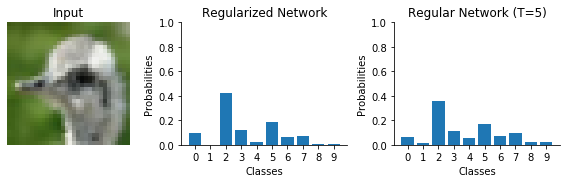

In [62]:
i = np.random.randint(len(x_train))
#i = 54270
fig, ax = plt.subplots(1, 3, figsize=(10,2.5), gridspec_kw={'width_ratios': [1.6, 2, 2], 'wspace': 0.3})
# plt.tight_layout()
plt.gcf().subplots_adjust(bottom=0.2)
ax[0].imshow(x_train[i])
ax[0].axis('off')
ax[0].set_title('Input')
ax[1].bar(np.linspace(0,9,10), preds['soft_teacher'][i])
ax[1].set_xticks(np.arange(0, 10, step=1))
ax[1].set_ylim(top=1)
ax[1].spines['top'].set_visible(False)
ax[1].spines['right'].set_visible(False)
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Probabilities')
ax[1].set_title('Regularized Network')
ax[2].bar(np.linspace(0,9,10), preds['teacher'][i])
ax[2].set_xticks(np.arange(0, 10, step=1))
ax[2].set_ylim(top=1)
ax[2].spines['top'].set_visible(False)
ax[2].spines['right'].set_visible(False)
ax[2].set_xlabel('Classes')
ax[2].set_ylabel('Probabilities')
ax[2].set_title('Regular Network (T=5)')
plt.savefig('figures_cifar/cifar_{}.pdf'.format(i))
plt.show()

#plt.savefig('foo.png')

In [ ]:
from collections import Counter

pairs = [(x[0], x[1]) for x in np.argsort(preds_st)]
counts = Counter(pairs)
counts.most_common(len(counts))

In [ ]:
import tensorflow as tf
a = [[1, 10, 7, 9, 3, 66], [6, 4, 3, 2, 100, 0]]
b = tf.sort(a,axis=-1,direction='ASCENDING',name=None)
c = tf.keras.backend.eval(b)
c

In [59]:
model['student'].summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 3072)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 800)               2458400   
_________________________________________________________________
dense_21 (Dense)             (None, 800)               640800    
_________________________________________________________________
dense_22 (Dense)             (None, 10)                8010      
_________________________________________________________________
o2 (Activation)              (None, 10)                0         
Total params: 3,107,210
Trainable params: 3,107,210
Non-trainable params: 0
_________________________________________________________________
